# Notebook 2 : UK data analysis + LDA + Filtering the top 20 newspapers

In [1]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import tldextract
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
from gensim import corpora, models
nltk.download('stopwords')
SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meftahzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Filter out the non relevant tags and subdomains of the top 20 domains + Notebook 1 cleaning :

* the table with the top 20 domains and their relevant tags can be found under "domain filtering.pdf"

In [2]:
relevant= ["bbc.co.uk/news/",
"Ablink.editorial.theguardian.com",
"theguardian.com/news/",
"theguardian.com/world/",
"theguardian.com/commentisfree/",
"theguardian.com/us-news/",
"theguardian.com/uk-news/",
"theguardian.com/politics/",
"theguardian.com/education/",
"theguardian.com/society/",
"theguardian.com/science/",
"theguardian.com/business/",
"theguardian.com/money/",
"theguardian.com/sport/",
"theguardian.com/australia-news/",
"theguardian.com/travel/",
"theguardian.com/technology/",
"theguardian.com/commentisfree/",
"dailymail.co.uk/news/",
"dailymail.co.uk/columnists/",
"dailymail.co.uk/debate/",
"dailymail.co.uk/femail/",
"dailymail.co.uk/health/",
"dailymail.co.uk/money/",
"dailymail.co.uk/sport/",
"dailymail.co.uk/travel/",
"dailymail.co.uk/tvshowbiz/",
"news.sky.com/story/",
"thesun.co.uk/fabulous/",
"thesun.co.uk/money/",
"thesun.co.uk/news/",
"thesun.co.uk/sport/",
"thesun.co.uk/travel/",
"thesun.co.uk/tech/",
"www.telegraph.co.uk/politics/",
"www.telegraph.co.uk/news/",
"express.co.uk",
"metro.co.uk",
"itv.com/news",
"independent.co.uk/news",
"thetimes.co.uk/article",
"www.channel4.com/news",
"inews.co.uk/news",
"thetelegraphandargus.co.uk/news",
"nytimes.com/20",
"standard.co.uk/news",
"kentonline.co.uk",
"ft.com/content",
"eveningtimes.co.uk/news",
"eveningtimes.co.uk/content"]

In [3]:
news = pd.DataFrame()
DATA_FILES = ['uk/newspaper.json']
for filepath in DATA_FILES:
    current_news = pd.read_json(filepath, lines=True)
    current_news['country'] = filepath[:2]
    news = news.append(current_news)
    

news.reset_index(inplace=True, drop=True)

In [4]:
media_portals= news[(news['meta_lang'] == 'en') | (news['meta_lang'].isnull())] #select only articles with 'en' meta_lang or with empty

In [5]:
media_portals=media_portals[media_portals.url.str.contains('|'.join(relevant))]

In [6]:
media_portals=media_portals[media_portals["url"].str.contains("express.co.uk/showbiz|discountcode.metro.co.uk|Link.news.metro.co.uk|www.metro.co.uk|api.metro.co.uk")==False]
media_portals

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk
7,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
8,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk
20,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk
21,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
120568,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk
120569,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk
120576,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk
120579,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk


## check how many articles we have with all the tags from the top 20:

In [7]:
alltwenty= ["bbc.co.uk",
"theguardian.com",
"dailymail.co.uk",
"sky.com",
"thesun.co.uk",
"www.telegraph.co.uk",
"express.co.uk",
"metro.co.uk",
"itv.com",
"independent.co.uk",
"thetimes.co.uk",
"www.channel4.com",
"inews.co.uk",
"thetelegraphandargus.co.uk",
"nytimes.com",
"standard.co.uk",
"kentonline.co.uk",
"ft.com",
"eveningtimes.co.uk",
"buzzfeed.com"]

In [8]:
len(news[news.url.str.contains('|'.join(alltwenty))])

86346

## Checking the number of occurences of articles based on title and text seperately :

In [9]:
news[news.text.str.contains("That's why our new email newsletter will deliver a mobile-friendly snapshot of inews.co.uk", case=False, na=False)]

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country
1146,Mendip House care home has been fined a deriso...,The i's Essential Daily Briefing\n\nWe know th...,[Ian Birrell],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_74657_web_page.html,inews.co.uk/opinion/columnists/mendip-house-au...,NaN,uk
1172,The lesbian ‘blood sisters’ who cared for gay ...,The i's Essential Daily Briefing\n\nWe know th...,[Dr Kate Lister],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78007_web_page.html,inews.co.uk/opinion/comment/the-lesbian-blood-...,NaN,uk
1173,‘There were days we couldn’t buy food’: why as...,The i's Essential Daily Briefing\n\nWe know th...,[Nahla Ellozi],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-15_78008_web_page.html,inews.co.uk/opinion/why-asylum-seekers-should-...,NaN,uk
2595,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8058_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
2596,"When is Mother’s Day 2019, what are origins of...",The i's Essential Daily Briefing\n\nWe know th...,[David Hughes],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-03-16_8059_mobile_.html,inews.co.uk/light-relief/offbeat/mothers-day-2...,NaN,uk
...,...,...,...,...,...,...,...,...,...,...,...
93204,Michael Gove to challenge Boris Johnson for To...,The i's Essential Daily Briefing\n\nWe know th...,[Nick Duffy],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_23048_web_page.html,inews.co.uk/news/politics/michael-gove-to-chal...,NaN,uk
93502,Can UK enter Eurovision after Brexit? How leav...,The i's Essential Daily Briefing\n\nWe know th...,[Charlie Duffield],[https://edition.pagesuite-professional.co.uk/...,None,en,[],GER_2019-05-26_43942_web_page.html,inews.co.uk/news/brexit/eurovision-2019-brexit...,NaN,uk
93503,Matt Hancock warns the next Prime Minister not...,The i's Essential Daily Briefing\n\nWe know th...,[Georgina Littlejohn],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_43943_web_page.html,inews.co.uk/news/matt-hancock-warns-next-prime...,NaN,uk
93600,Nigel Farage ‘will take over’ as leader of the...,The i's Essential Daily Briefing\n\nWe know th...,[Serina Sandhu],[https://images-i.jpimedia.uk/imagefetch/c_fil...,None,en,[],GER_2019-05-26_48204_web_page.html,inews.co.uk/news/nigel-farage-leader-brexit-pa...,NaN,uk


In [10]:
pd.DataFrame(media_portals.text.value_counts())

text
The i's Essential Daily Briefing\n\nWe know tha...   349
What term do you want to search? Search with go...   278
Make informed decisions with the FT\n\nKeep abr...   171
Have Your Say                                         56
i Search\n\nCheck the URL for errors or try our...    52
...                                                  ...
This is the heartbreaking moment that a US Army...     1
Image copyright Getty Images\n\nEnergy firms ne...     1
Mary J. Blige and Natasha Lyonne cut stylish fi...     1
WITH ski holidays every year, a pony and a bran...     1
Image copyright Getty Images Image caption Acti...     1

[30193 rows x 1 columns]

In [11]:
media_portals['txt_counts'] = media_portals['text'].map(media_portals['text'].value_counts())
media_portals['title_counts'] = media_portals['title'].map(media_portals['title'].value_counts())

In [12]:
criteria=50
s=media_portals[media_portals['txt_counts']<=criteria]
print("Number of articles with text occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[media_portals['title_counts']<=criteria]
print("Number of articles with title occurence less than "+ str(criteria) +" :" + str(len(s)))
s=media_portals[(media_portals['txt_counts']<=criteria) & (media_portals['title_counts']<=criteria)]
print("Number of articles with title and text occurence combined less than "+ str(criteria) +" :" + str(len(s)))
s.reset_index(inplace=True, drop=True)

Number of articles with text occurence less than 50 :36541
Number of articles with title occurence less than 50 :37373
Number of articles with title and text occurence combined less than 50 :36265


## Data preprocessing :

In [13]:
a=s
a.drop_duplicates(subset='text', keep='first')
a.drop_duplicates(subset='title', keep='first')

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0
5,Quiz of the Week: How is Bond going green?,It's the weekly news quiz - have you been payi...,None,[https://sb.scorecardresearch.com/p?c1=2&c2=17...,None,en,[],GER_2019-03-15_2098_web_page.html,www.bbc.co.uk/news/stories-47558696,NaN,uk,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0
36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0
36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0
36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0


## Delete handles, image caption/credits, links, money amounts, phone numbers, and navigation menus

In [14]:
r_ignore_case = {
    'handle': r'\S+@\S+',
    'link': r'((visit|at)\s+)*(\S+).(com|org)((/|\S)*)',
    'money': r'\$\d*',
    'phone': r'(\d-)*(\d+-\d+-\d+)' ,
    'menu': r'(?<=•)[^•]*(?=•)'
}
r_set_case = {
    'photographer-credits': r'PHOTO(GRAPHER)*:(\s)*(([A-Z][A-Za-z]*)\s*){1,3}',
    'graphics': r'Graphic([^.])'
}

In [15]:
def filter_text(text):
    for regex in r_ignore_case:
        text = re.sub(regex, '', text, re.I)
    for regex in r_set_case:
        text = re.sub(regex, '', text)
    return text

In [16]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return [stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text]

In [17]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    return text

In [18]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text))
SW = list(response['words'])
def remove_stopwords(text):
    return [word for word in text if not word in SW]

In [19]:
def clean_text(text):
    text = filter_text(text)
    text = process_text(text)
    text = remove_stopwords(text)
    text = lemmatize_stemming(text)
    return text

In [20]:
a['clean_text']=a['text'].apply(lambda x: clean_text(str(x)))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0,"[imag, man, lay, flower, victim, terror, attac..."
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl..."
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl..."
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr..."
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[imag, copyright, getti, imag, imag, lord, ste..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns..."
36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ..."
36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, come, raci..."
36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, call, vodafon, deal, amaz..."


In [22]:
a['length']=a['clean_text'].apply(lambda x: len(x))

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distributon of number of words in the articles')

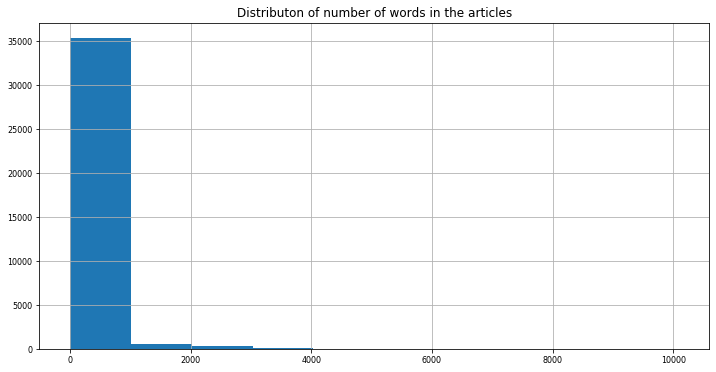

In [23]:
a['length'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the articles")

In [24]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'imag', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'nh', "getti", "pa","don","ap","afp","reuter","pictur", "ve", "didn", "share","septemb",
                   "august","octob","jo","thoma","june","juli","fox","bu",
                  "st","ms"]
my_stopwords = SW + stopwords_verbs + stopwords_other

a['clean_text']= a['clean_text'].map(lambda tokens: [token for token in tokens if token not in my_stopwords])

/home/meftahzi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
a

,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,length
0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0,"[man, lay, flower, victim, terror, attack, mem...",9
1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302
2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302
3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr...",467
4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[lord, steel, evid, independ, inquiri, child, ...",378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns...",384
36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ...",134
36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, racism, yo...",285
36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, vodafon, deal, amazon, ec...",160


In [26]:
a= a.reset_index()

In [27]:
data_lemmatized = list(a['clean_text'])

In [28]:
bigram = gensim.models.Phrases(data_lemmatized, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in data_lemmatized]

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(texts)
# Filter out words that occur less than 30 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=1, no_above=0.4)

# Create Corpus
texts = texts

In [30]:
corpus = [id2word.doc2bow(text) for text in texts]

In [31]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 94872
Number of documents: 36265


### Crime  - Economic situation - Rising prices/inflation/cost of living - Taxation - Unemployment - Terrorism - Housing - Government debt - Immigration - Health and social security - The education system - Pensions - The environment, climate and energy issues  - Brexit

## Build LDA model

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """ 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num_topics, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num_topics,
                                                   per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=25, step=1)

-2.0871502640674855
-2.200246990216176
-2.0044306988550296
-2.303381994129096
-2.7222155068306253
-3.0493553955902373
-2.328748565097716
-3.7371522558012793
-2.694305521079964
-3.26437573036085
-2.564942025006482
-3.2279148430503786
-2.6484159216520693
-3.517922645419195
-3.083515871201122


'''finding the optimal number of topics is to build
many LDA models with different values of number of topics (k) 
and pick the one that gives the highest coherence value.
Best coherence for umass is typically the minimum
'''

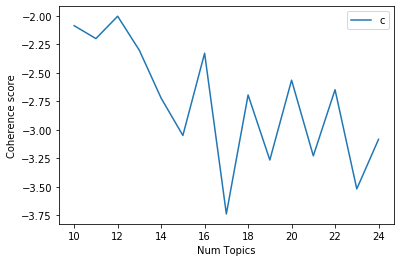

In [35]:
# Show graph
limit=25; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
num=17
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics= num, 
                                                   random_state=100,
                                                   iterations = 300,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=2,
                                                   alpha=[0.01]*num,
                                                   per_word_topics=True)

In [37]:

for i,topic in lda_model.show_topics(formatted=True, num_topics=18, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.049*"polic" + 0.030*"attack" + 0.027*"protest" + 0.020*"london" + 0.019*"offic" + 0.016*"man" + 0.014*"murder" + 0.013*"victim" + 0.012*"forc" + 0.012*"arrest" + 0.011*"kill" + 0.009*"women" + 0.009*"men" + 0.007*"group" + 0.007*"investig" + 0.006*"incid" + 0.006*"crime" + 0.006*"member" + 0.006*"woman" + 0.006*"carri"

1: 0.016*"credit" + 0.011*"good" + 0.010*"babi" + 0.010*"uk" + 0.009*"week" + 0.008*"sun" + 0.008*"celebr" + 0.007*"royal" + 0.007*"start" + 0.006*"scotland" + 0.006*"work" + 0.006*"feel" + 0.006*"spend" + 0.006*"point" + 0.006*"queen" + 0.006*"ll" + 0.006*"flood" + 0.005*"lot" + 0.005*"explain" + 0.005*"visit"

2: 0.041*"pay" + 0.027*"free" + 0.024*"sell" + 0.024*"cost" + 0.024*"custom" + 0.024*"compani" + 0.022*"busi" + 0.021*"food" + 0.021*"uk" + 0.020*"price" + 0.020*"product" + 0.020*"buy" + 0.019*"money" + 0.017*"store" + 0.016*"tax" + 0.015*"amazon" + 0.015*"cut" + 0.014*"save" + 0.012*"deal" + 0.012*"shop"

3: 0.377*"offer" + 0.066*"chancellor" + 0.018*"phi

In [38]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.188440 -0.003599       1        1  13.948732
8      0.141982 -0.013662       2        1  10.452229
16     0.144605  0.062185       3        1  10.174215
4      0.181029 -0.189242       4        1   9.860466
10     0.117954  0.133722       5        1   9.598758
0      0.108778  0.054770       6        1   7.816520
15     0.181172 -0.101279       7        1   6.868016
13     0.017651  0.190622       8        1   6.490771
14    -0.023939 -0.232676       9        1   5.842834
12     0.117722  0.016110      10        1   5.658634
2      0.004599 -0.147799      11        1   3.436151
9     -0.075481  0.229063      12        1   2.899195
7     -0.047785  0.048738      13        1   2.202093
17    -0.062126  0.132233      14        1   1.685930
11    -0.158449 -0.096373      15        1   1.307560
6     -0.235737  0.048317      16        1   1.040488
5     -0.283420 -0.097186      17        1   0.644996
3     -0.316994 -0.033944      18        1   0.072412, topic_info=              Term          Freq         Total Category  logprob  loglift
1613        brexit  39786.000000  39786.000000  Default  30.0000  30.0000
195       children  24494.000000  24494.000000  Default  29.0000  29.0000
112          parti  38860.000000  38860.000000  Default  28.0000  28.0000
298          polic  40172.000000  40172.000000  Default  27.0000  27.0000
348          trump  15751.000000  15751.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
6955          leak      0.039687      1.284122  Topic18 -12.0775   3.7537
6628  bori_johnson      0.039692      1.285697  Topic18 -12.0774   3.7527
5783          exam      0.039686      1.284093  Topic18 -12.0776   3.7537
5918     tv_licenc      0.039687      1.285226  Topic18 -12.0775   3.7529
5430       footbal      0.039686      1.284906  Topic18 -12.0776   3.7531

[1074 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4644     15  0.990116     abhorr
368      10  0.283073       abus
368      16  0.716810       abus
369       1  0.055484     access
369       3  0.028469     access
...     ...       ...        ...
509       3  0.328481  yesterday
509       7  0.671407  yesterday
3845      8  0.999637    younger
2264      5  0.005531     youtub
2264     14  0.993849     youtub

[2553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 17, 5, 11, 1, 16, 14, 15, 13, 3, 10, 8, 18, 12, 7, 6, 4])

In [43]:
max(lda_model.get_document_topics(corpus[0]))
l=[]
for i in range(len(data_lemmatized)):
    l.append(max(lda_model.get_document_topics(corpus[i]), key=lambda x:x[1]))

In [44]:
l

[(0, 0.67581826),
 (0, 0.35345778),
 (0, 0.35345832),
 (0, 0.47416955),
 (15, 0.4111356),
 (9, 0.4864988),
 (1, 0.41756094),
 (2, 0.82539755),
 (0, 0.4414465),
 (0, 0.493957),
 (0, 0.38359135),
 (8, 0.5398142),
 (7, 0.72252023),
 (4, 0.4566389),
 (0, 0.4939576),
 (0, 0.48069704),
 (1, 0.28894156),
 (7, 0.45941132),
 (14, 0.3715166),
 (14, 0.60474885),
 (12, 0.31425202),
 (0, 0.55117095),
 (4, 0.38489404),
 (14, 0.609562),
 (14, 0.44019532),
 (0, 0.7034002),
 (12, 0.61094004),
 (9, 0.4506021),
 (12, 0.58814824),
 (0, 0.6155303),
 (15, 0.53969055),
 (1, 0.5078397),
 (4, 0.8054109),
 (12, 0.6100586),
 (9, 0.5802961),
 (7, 0.45940843),
 (8, 0.4997159),
 (16, 0.4446129),
 (16, 0.6387479),
 (0, 0.20539016),
 (15, 0.41113693),
 (8, 0.28751865),
 (1, 0.6896617),
 (1, 0.72759515),
 (0, 0.4342757),
 (1, 0.5425541),
 (0, 0.45689073),
 (0, 0.64622724),
 (15, 0.3735085),
 (4, 0.58103746),
 (10, 0.76982707),
 (13, 0.7139092),
 (0, 0.42454755),
 (12, 0.5386426),
 (1, 0.36076158),
 (15, 0.516221),
 (1

usage of LDA is when you have no labels, and you want to identify which documents are semantically similar to each other, without necessarily determining what the correct class label for the documents is.

In [45]:
a["topic_prob"]= l

In [46]:
a

,index,title,text,authors,imgs,movies,meta_lang,meta_keywords,htmlfile,url,error,country,txt_counts,title_counts,clean_text,length,topic_prob
0,0,LIVE: NZ terror attacks - Gun law reforms with...,Image:\n\nA man lays flowers for victims of th...,None,[https://e3.365dm.com/19/03/768x432/skynews-ne...,None,en,[],GER_2019-03-15_71_web_page.html,news.sky.com/story/live-significant-number-kil...,NaN,uk,1.0,1.0,"[man, lay, flower, victim, terror, attack, mem...",9,"(0, 0.67581826)"
1,1,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1075_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302,"(0, 0.35345778)"
2,2,Australian senator blames immigration for mosq...,An Australian senator has provoked outrage aft...,[Jane Wharton],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,None,en,[],GER_2019-03-15_1076_web_page.html,metro.co.uk/2019/03/15/australian-senator-blam...,NaN,uk,2.0,2.0,"[australian, senat, provok, outrag, blame, isl...",302,"(0, 0.35345832)"
3,3,Christchurch shootings: 49 dead in New Zealand...,Media playback is unsupported on your device M...,None,[http://ssc.api.bbc.com/?c1=2&c2=19293874&ns_s...,None,en,[],GER_2019-03-15_1563_web_page.html,www.bbc.co.uk/news/world-asia-47578798,NaN,uk,2.0,2.0,"[media, playback, unsupport, devic, media, chr...",467,"(0, 0.47416955)"
4,4,David Steel suspended by Liberal Democrats ove...,Image copyright Getty Images Image caption Lor...,None,[https://ichef.bbci.co.uk/news/320/cpsprodpb/1...,None,en,[],GER_2019-03-15_1564_web_page.html,www.bbc.co.uk/news/uk-scotland-scotland-politi...,NaN,uk,2.0,2.0,"[lord, steel, evid, independ, inquiri, child, ...",378,"(15, 0.4111356)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36260,36260,Conservative leadership field slims to six as ...,Conservative leadership field slims to six as ...,"[Greg Heffer, Political Reporter]",[https://e3.365dm.com/19/06/768x432/skynews-ma...,None,en,[],GER_2019-06-15_1622_mobile_.html,news.sky.com/story/conservative-leadership-fie...,NaN,uk,1.0,1.0,"[conserv, leadership, field, slim, bori, johns...",384,"(15, 0.35757023)"
36261,36261,'Glazed ring' donut jokes gets city boss from ...,Sign me up for news alerts\n\nA city boss has ...,None,"[http://fox13now.com/1x1.gif, http://fox13now....",None,en,"[Business News, Quirky, Kent, People & Employm...",GER_2019-06-15_1623_mobile_.html,www.kentonline.co.uk/kent/news/boss-suspended-...,NaN,uk,1.0,1.0,"[sign, news, alert, citi, boss, suspend, buy, ...",134,"(12, 0.21289626)"
36262,36262,Former Arsenal footballer Ian Wright taught hi...,Ian Wright has opened up about warning his chi...,[Rishma Dosani],[https://sb.scorecardresearch.com/p?c1=2&c2=60...,[https://www.youtube.com/embed/E7Cs9MJnwuI?ver...,en,[],GER_2019-06-15_2463_mobile_.html,metro.co.uk/2019/06/15/ian-wright-taught-child...,NaN,uk,1.0,1.0,"[ian, wright, open, warn, children, racism, yo...",285,"(10, 0.42030942)"
36263,36263,Amazon Echo price drops AGAIN as owners get a ...,Amazon Echo now gets voice calling from Vodafo...,[David Snelling],[https://cdn.images.express.co.uk/img/covers/7...,None,en,[],GER_2019-06-15_4600_mobile_.html,www.express.co.uk/life-style/science-technolog...,NaN,uk,1.0,1.0,"[amazon, echo, voic, vodafon, deal, amazon, ec...",160,"(2, 0.28165168)"


In [49]:
# Number of Documents for Each Topic
topi = a['topic_prob'].apply(lambda x: x[0])
topic_perce= a['topic_prob'].apply(lambda x: x[1])
topic_counts=topi.value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show

df_dominant_topics['dominant_topic'] = df_dominant_topics.index
df_dominant_topics

,Num_Documents,Perc_Documents,dominant_topic
1,7791,0.2148,1
10,5888,0.1624,10
16,4929,0.1359,16
0,4203,0.1159,0
14,3012,0.0831,14
13,2539,0.0700,13
15,2249,0.0620,15
12,1785,0.0492,12
7,1127,0.0311,7
4,921,0.0254,4


In [54]:
import matplotlib.colors as mcolors
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

IndexError: list index out of range

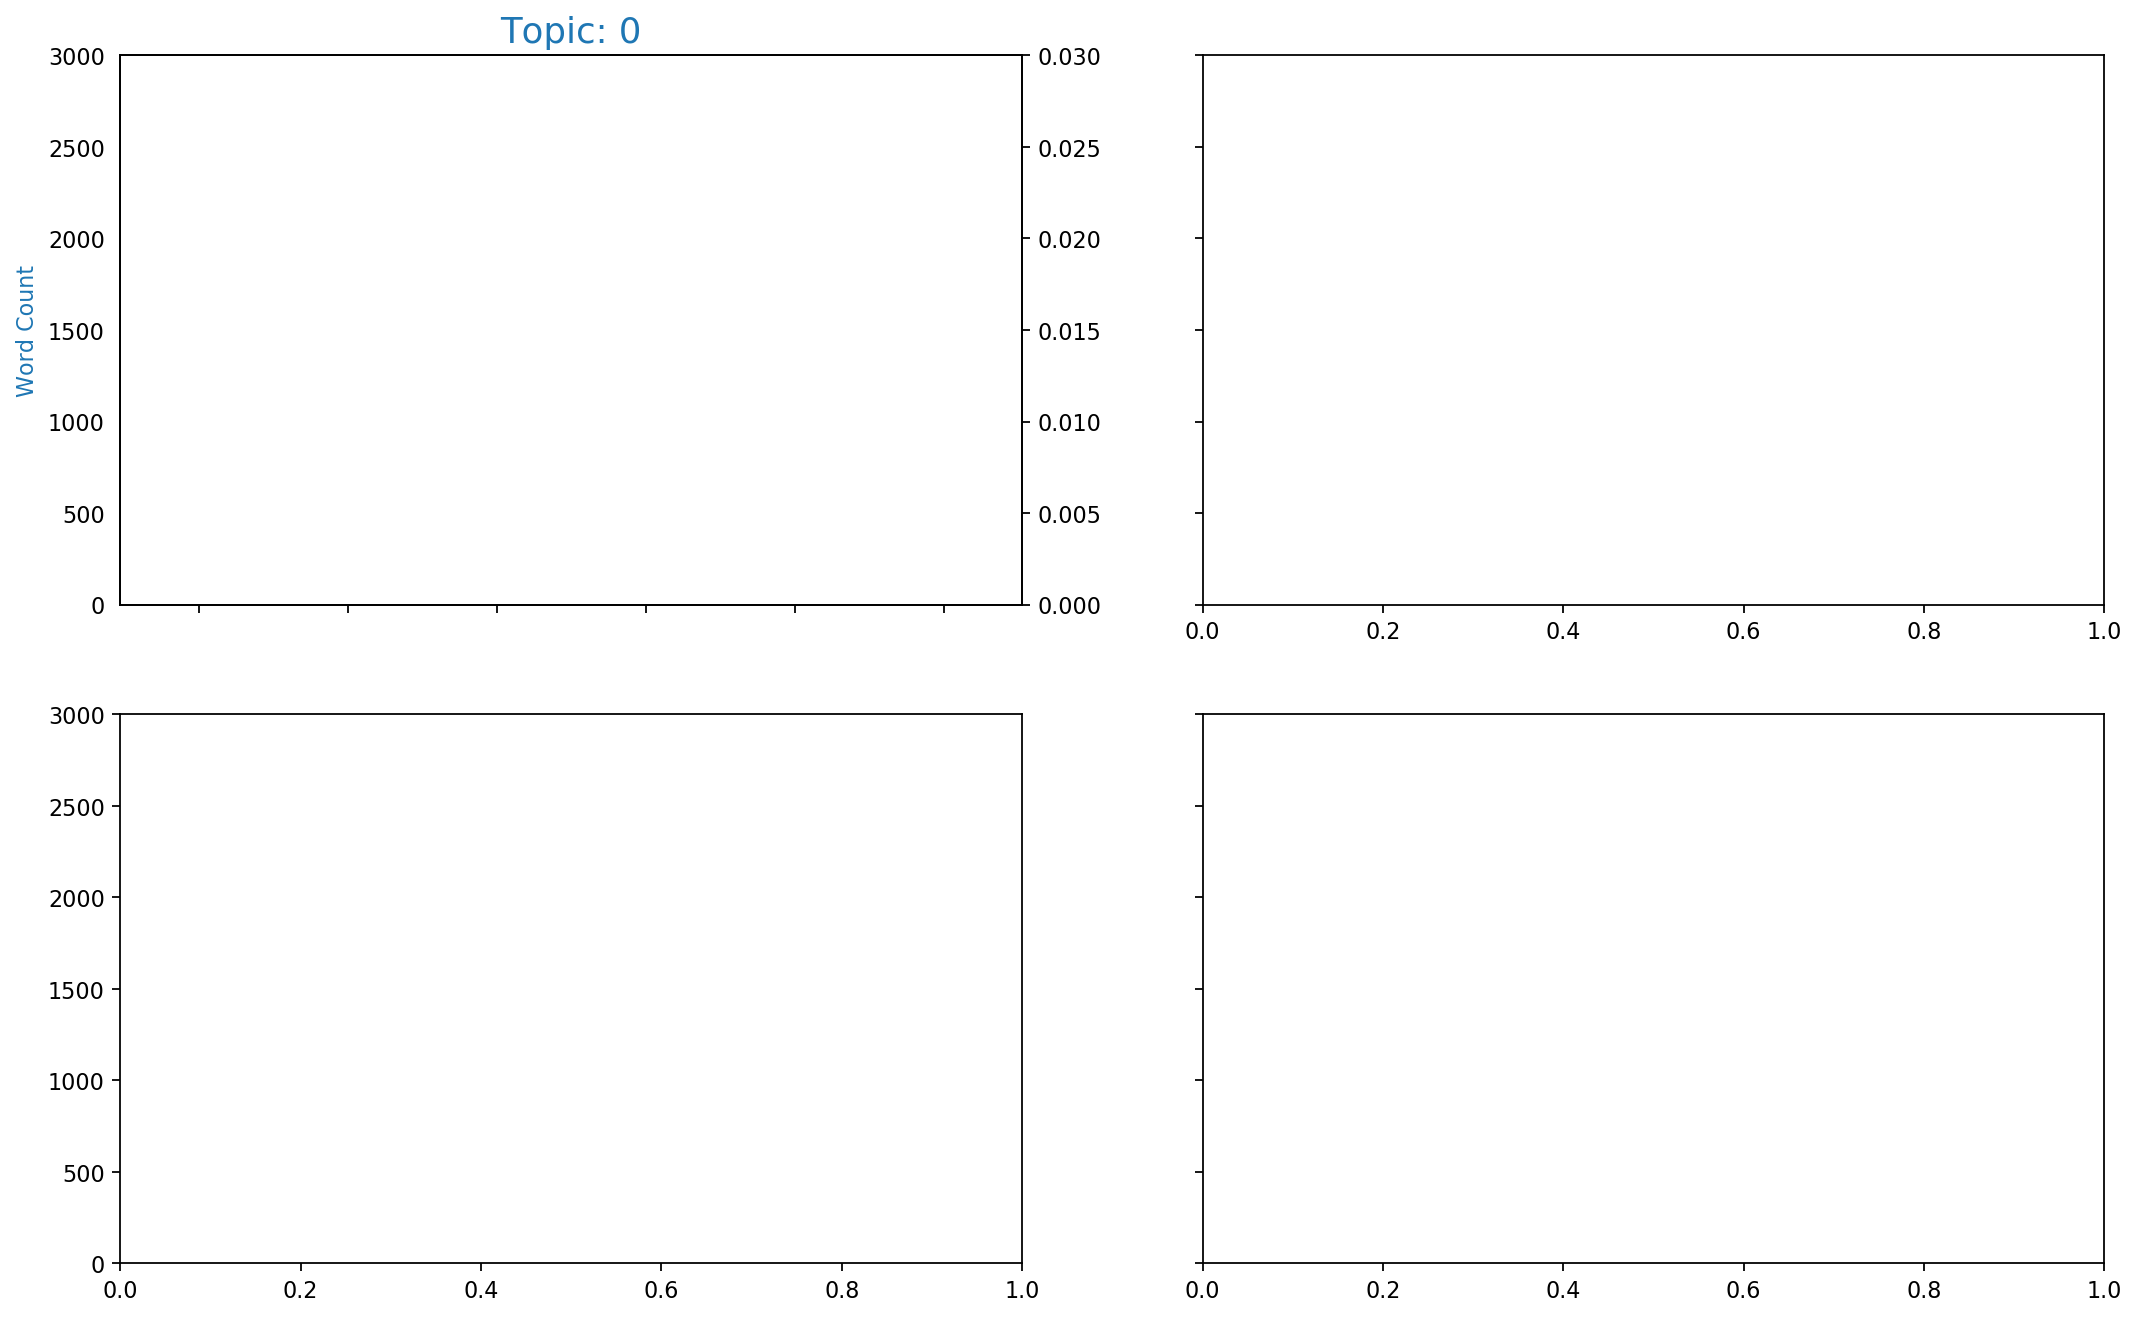

In [55]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')